### InceptionV3 transfer learning

#### Import necessary libraries

In [1]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

import datetime

from sklearn.utils import class_weight
from keras.preprocessing import image                  
from tqdm import tqdm


c:\program files (x86)\microsoft visual studio\shared\anaconda3_64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Import Dataset

In [2]:
start_time = datetime.datetime.now()

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    oct_files = np.array(data['filenames'])
    oct_targets = np_utils.to_categorical(np.array(data['target']), 4)
    return oct_files, oct_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('OCT2017-RESIZED-V1/train')
valid_files, valid_targets = load_dataset('OCT2017-RESIZED-V1/valid')
test_files, test_targets = load_dataset('OCT2017-RESIZED-V1/test')

# load list of oct names
oct_names = [item[20:-1] for item in sorted(glob("OCT2017-RESIZED-V1/train/*/"))]

# print statistics about the dataset
print('There are %d total oct categories.' % len(oct_names))
print('There are %s total oct images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training oct images.' % len(train_files))
print('There are %d validation oct images.' % len(valid_files))
print('There are %d test oct images.'% len(test_files))

print('Ellapsed: ' + str(datetime.datetime.now() - start_time))

There are 4 total oct categories.
There are 7020 total oct images.

There are 5082 training oct images.
There are 938 validation oct images.
There are 1000 test oct images.
Ellapsed: 0:00:59.699853


#### Pre-process the Data

In [3]:
from matplotlib.pyplot import imshow
from PIL import Image

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Explore feasibility of mean subtraction algorithm

In [67]:
%matplotlib inline

mean_substraction_test_img = "OCT2017-RESIZED-V1/train/CNV/CNV-4020729-79.jpeg"

Original Image


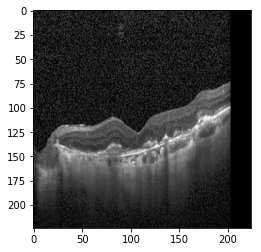

In [68]:
print('Original Image')

imshow(np.asarray(image.load_img(mean_substraction_test_img, target_size=(224, 224))))

The most identifiable features of the images are mostly represented in grayscaled shapes. Applying mean pixel normalization will be detrimental for this classification problem since a lot of the information in the image will be lost. 

The previous statement can be proven by displaying an image with mean pixel normalization. Please see the image below. A lot of the important features have been removed from the image. 

Preprocessed Image


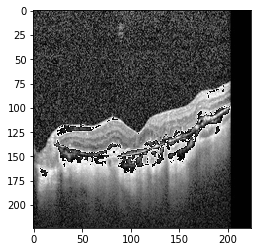

In [69]:
print('Preprocessed Image')

from keras.preprocessing.image import img_to_array
image = image.img_to_array(image.load_img(mean_substraction_test_img, target_size=(224, 224)))

imshow(np.asarray(preprocess_input(image)))

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

start_time = datetime.datetime.now()
                           
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

print('Ellapsed: ' + str(datetime.datetime.now() - start_time))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.34it/s]


Ellapsed: 0:02:41.514946


---
<a id='step5'></a>
### Utilize InceptionV3 pretrained model to predict OCT diagnosis


- [InceptionV3](https://keras.io/applications/#inceptionv3) pretrained on imagenet


In [5]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

#### Compute class weights

In [13]:

class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(train_targets, axis=1)),
                                                 np.argmax(train_targets, axis=1))

print(class_weight)

[0.77658924 1.35303514 1.03376729 0.99413146]


#### Instantiate InceptionV3 model pretrained on imagenet

##### InceptionV3 parameters 

- include_top set to false to fine-tune the last layers to make predictions on the 4 classification categories

##### Create architecture and train model

- Freeze the first 200 layers to use pretrain weights 
- Enable training on the rest 110 layers. 
- Compile the model using the following parameters:
    - optimizer = rmsprop
    - loss = categorical_crossentropy
    
- Train the model 

- Repeat process
    - Freeze the first 200 layers to use pretrain weights 
    - Enable training on the rest 110 layers. 
    - Compile the model using the following parameters:
        - optimizer = Stochastic Gradient Descent with learning rate 0.0001 and momentum=0.9
        - loss= categorical_crossentropy
- Train model

- epochs was set to 5
    


In [14]:
start_time = datetime.datetime.now()

#InceptionV
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

# Create the layer to make predictions on the 4 different classes using a softmax activation function.
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

epochs = 5


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers[:200]:
   layer.trainable = False
for layer in base_model.layers[200:]:
   layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, 
          batch_size=20, 
          class_weight=class_weight,
          callbacks=[checkpointer], 
          verbose=2)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 200 layers and unfreeze the rest:
for layer in model.layers[:200]:
   layer.trainable = False
for layer in model.layers[200:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs,
          class_weight=class_weight,
          batch_size=20, 
          callbacks=[checkpointer], 
          verbose=2)


print('Ellapsed: ' + str(datetime.datetime.now() - start_time))

Train on 5082 samples, validate on 938 samples
Epoch 1/5
 - 174s - loss: 0.9202 - val_loss: 8.0949

Epoch 00001: val_loss improved from inf to 8.09489, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/5
 - 130s - loss: 0.2771 - val_loss: 2.8307

Epoch 00002: val_loss improved from 8.09489 to 2.83068, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 3/5
 - 130s - loss: 0.1801 - val_loss: 4.3989

Epoch 00003: val_loss did not improve from 2.83068
Epoch 4/5
 - 131s - loss: 0.1388 - val_loss: 2.5328

Epoch 00004: val_loss improved from 2.83068 to 2.53279, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 5/5
 - 130s - loss: 0.1293 - val_loss: 4.2474

Epoch 00005: val_loss did not improve from 2.53279
0 input_1 False
1 conv2d_1 False
2 batch_normalization_1 False
3 activation_1 False
4 conv2d_2 False
5 batch_normalization_2 False
6 activation_2 False
7 conv2d_3 False
8 batch_normalization_3 False
9 activation_3 False
10 max_pooling2d_1 False


301 activation_88 True
302 activation_89 True
303 activation_92 True
304 activation_93 True
305 batch_normalization_94 True
306 activation_86 True
307 mixed9_1 True
308 concatenate_2 True
309 activation_94 True
310 mixed10 True
Train on 5082 samples, validate on 938 samples
Epoch 1/5
 - 130s - loss: 0.0590 - val_loss: 3.2266

Epoch 00001: val_loss did not improve from 2.53279
Epoch 2/5
 - 122s - loss: 0.0437 - val_loss: 3.0979

Epoch 00002: val_loss did not improve from 2.53279
Epoch 3/5
 - 122s - loss: 0.0536 - val_loss: 3.1345

Epoch 00003: val_loss did not improve from 2.53279
Epoch 4/5
 - 122s - loss: 0.0500 - val_loss: 3.1849

Epoch 00004: val_loss did not improve from 2.53279
Epoch 5/5
 - 122s - loss: 0.0403 - val_loss: 3.1428

Epoch 00005: val_loss did not improve from 2.53279
Ellapsed: 0:23:16.761596


#### Load Model weights

In [15]:
model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

#### Test model accuracy

In [16]:
# get index of predicted dog breed for each image in test set
diagnosis_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(diagnosis_predictions)==np.argmax(test_targets, axis=1))/len(diagnosis_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2000%


#### Sklearn classification_report
- precision    
- recall  
- f1-score   
- support

In [30]:
from sklearn.metrics import classification_report

print('\n', classification_report(np.argmax(test_targets, axis=1), diagnosis_predictions, target_names=['CNV','DME','DRUSEN','NORMAL']))


              precision    recall  f1-score   support

        CNV       1.00      0.34      0.51       250
        DME       0.89      0.92      0.91       250
     DRUSEN       0.63      0.98      0.77       250
     NORMAL       0.93      1.00      0.96       250

avg / total       0.86      0.81      0.79      1000



#### Confusion matrix

Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

Confusion matrix, without normalization
[[ 86  28 136   0]
 [  0 231   5  14]
 [  0   0 245   5]
 [  0   0   0 250]]
Normalized confusion matrix
[[0.34 0.11 0.54 0.  ]
 [0.   0.92 0.02 0.06]
 [0.   0.   0.98 0.02]
 [0.   0.   0.   1.  ]]


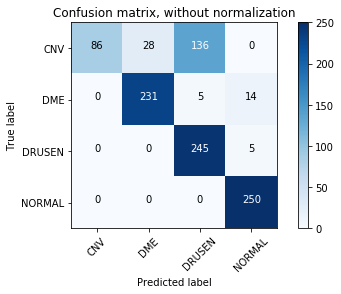

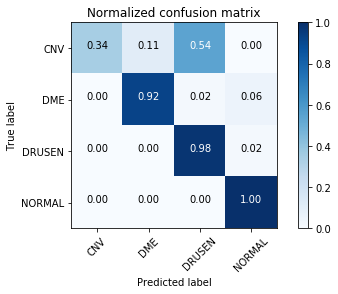

In [33]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

y_pred = diagnosis_predictions
y_test = np.argmax(test_targets, axis=1)
class_names = ['CNV','DME','DRUSEN','NORMAL']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()